## imports and defs

In [3]:
# from rnog_data.runtable import RunTable
# rnog_table = RunTable()
# rnog_table.get_table()
# rnog_table.get_table(stations=[13], start_time="2025-06-01 00:00:00", stop_time="2025-06-02 00:00:00")

In [4]:
# to read any rno-g data root file and plot waveforms and extract analysis variables such as snr
import sys, os, subprocess
from datetime import datetime, timezone
import matplotlib.cm as cm
sys.path.append(os.path.abspath('/data/user/sanyukta/rno_code'))
from reading.data_reading import *
from functions.functions import *
# supress warnings
import warnings
warnings.filterwarnings("ignore")
mattak_kwargs = {
    "backend" : "uproot",
    # "backend" : "pyroot"
}

In [5]:
# constants
pa_chs = [0,1,2,3]
hpols = [8,4]
uvs = [5,6,7]
deep_chs = np.concatenate((pa_chs,hpols,uvs))
up_lpdas = [13,16,19]
down_lpdas = [12,14,15,17,18,20]
lpdas = np.concatenate((up_lpdas,down_lpdas))
lpdas.sort()

## nur files

In [6]:
nur_dir = 'nur_files'
nur_files = [f for f in os.listdir(nur_dir) if f.endswith('.nur')]
nur_files.sort()
nur_files

['station11_run251156_combined.nur',
 'station11_run251172_combined.nur',
 'station11_run251179_combined.nur',
 'station11_run251181_combined.nur',
 'station11_run251182_combined.nur',
 'station12_run250230_combined.nur',
 'station12_run250231_combined.nur',
 'station12_run250232_combined.nur',
 'station12_run250233_combined.nur',
 'station12_run250234_combined.nur',
 'station12_run250235_combined.nur',
 'station12_run250236_combined.nur',
 'station12_run250237_combined.nur',
 'station12_run250238_combined.nur',
 'station12_run250239_combined.nur',
 'station12_run250240_combined.nur',
 'station12_run250241_combined.nur',
 'station12_run250248_combined.nur',
 'station12_run250249_combined.nur',
 'station12_run250250_combined.nur',
 'station12_run250251_combined.nur',
 'station12_run250252_combined.nur',
 'station12_run250253_combined.nur',
 'station12_run250254_combined.nur',
 'station12_run250255_combined.nur',
 'station12_run250256_combined.nur',
 'station12_run250257_combined.nur',
 

## plotting waveform

In [ ]:
from get_summit_weather_data.weather_reader import WeatherData
wd = WeatherData(years=[2025], use_official=True, use_unofficial=True)

runs = list(events.keys())
run_id = 11
trig_times = {}
trig_types = {}
wind_speeds = {}
for eve in eve_times[runs[run_id]].keys():
    if eve_times[runs[run_id]][eve]['eventNumber'] in events[runs[run_id]]:
        trig_times[eve_times[runs[run_id]][eve]['eventNumber']] = eve_times[runs[run_id]][eve]['triggerTime']
        trig_types[eve_times[runs[run_id]][eve]['eventNumber']] = eve_times[runs[run_id]][eve]['triggerType']
        wind_speeds[eve_times[runs[run_id]][eve]['eventNumber']] = wd.getWindSpeed(datetime.fromtimestamp(eve_times[runs[run_id]][eve]['triggerTime'], tz=timezone.utc))

trig_t = np.array([trig_times[k] for k in trig_times.keys()])
trig_dates = [datetime.fromtimestamp(ts, tz=timezone.utc) for ts in trig_t]
# trig_types

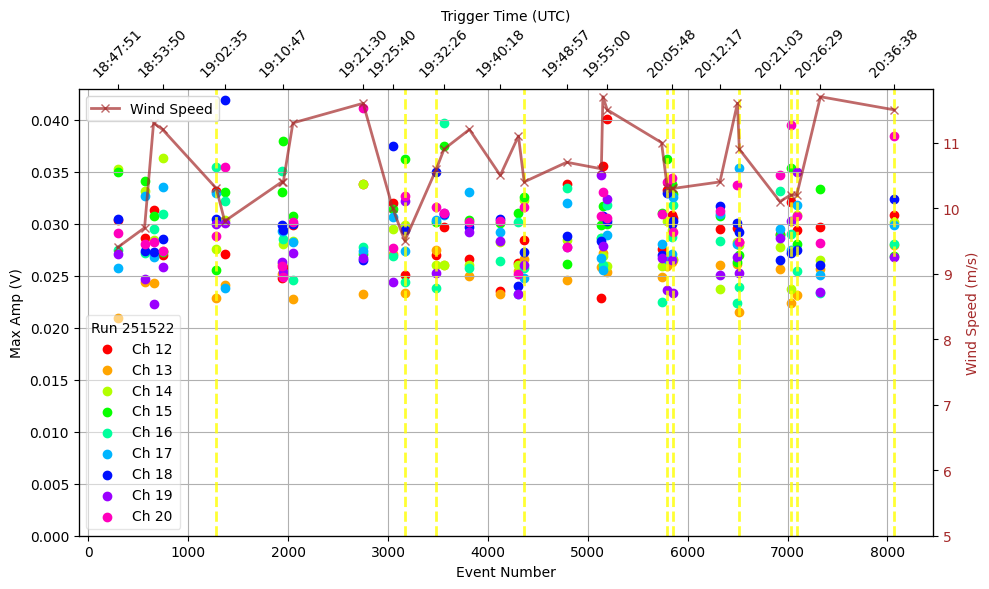

In [ ]:
# Create the main plot
fig, ax1 = plt.subplots(figsize=(10, 6))
colors = cm.hsv(np.linspace(0, 1, len(lpdas)+1))

# Add vertical lines for RADIANT0 trigger events
for eve_num in events[runs[run_id]]:
    if trig_types.get(eve_num) == 'RADIANT0':
        ax1.axvline(x=eve_num, color='pink', linestyle='--', alpha=0.8, linewidth=2.0)
    if trig_types.get(eve_num) == 'RADIANT1':
        ax1.axvline(x=eve_num, color='yellow', linestyle='--', alpha=0.8, linewidth=2.0)

for ch, color in zip(lpdas, colors):
    max_adc = [np.max(volts[runs[run_id]][eve][ch]) for eve in range(len(volts[runs[run_id]]))]
    ax1.scatter(events[runs[run_id]], max_adc, label=f'Ch {ch}', color=color)


ax1.set_ylim(0,)
ax1.set_xlabel('Event Number')
ax1.set_ylabel('Max Amp (V)')
ax1.legend(fancybox=True, framealpha=0.5, title=f'Run {runs[run_id]}')
ax1.grid()
# ax1.set_ylim(0,)

# Create second x-axis at the top for timestamps
ax2 = ax1.twiny()

# Set the same x-limits as the main axis
ax2.set_xlim(ax1.get_xlim())

# Create a mapping from event numbers to timestamps
event_to_time_map = {}
for i, event_num in enumerate(events[runs[run_id]]):
    event_to_time_map[event_num] = trig_dates[i]

# Set tick positions and labels for the timestamp axis
event_range = events[runs[run_id]]
min_event, max_event = min(event_range), max(event_range)

# Create more evenly distributed tick positions (increase n_ticks for more timestamps)
n_ticks = 15  # Increased number of timestamp ticks to show
tick_positions = np.linspace(min_event, max_event, n_ticks)

# Find the closest actual event numbers and their corresponding timestamps
tick_labels = []
actual_tick_positions = []

for pos in tick_positions:
    # Find the closest event number to this position
    closest_event = min(event_range, key=lambda x: abs(x - pos))
    actual_tick_positions.append(closest_event)
    
    # Get the corresponding timestamp
    timestamp_str = event_to_time_map[closest_event].strftime('%H:%M:%S')
    tick_labels.append(timestamp_str)

# Remove duplicates while preserving order
seen = set()
final_positions = []
final_labels = []
for pos, label in zip(actual_tick_positions, tick_labels):
    if pos not in seen:
        seen.add(pos)
        final_positions.append(pos)
        final_labels.append(label)

ax2.set_xticks(final_positions)
ax2.set_xticklabels(final_labels, rotation=45)
ax2.set_xlabel('Trigger Time (UTC)')
thresh = 0.2
ax1.hlines(y=thresh, xmin=events[runs[run_id]][0], xmax=events[runs[run_id]][-1], color='black', linestyle='--', label='Threshold (0.2 V)')

# Create secondary y-axis on the right for windspeed
ax3 = ax1.twinx()
wind_speeds_list = [wind_speeds[k] for k in events[runs[run_id]]]
ax3.plot(events[runs[run_id]], wind_speeds_list, color='brown', linewidth=2, label='Wind Speed', alpha=0.7, marker='x')
ax3.set_ylim(5,)
ax3.set_ylabel('Wind Speed (m/s)', color='brown')
ax3.tick_params(axis='y', labelcolor='brown')
ax3.legend()

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Run 251110: Events with Max Amp > 0.2 V')

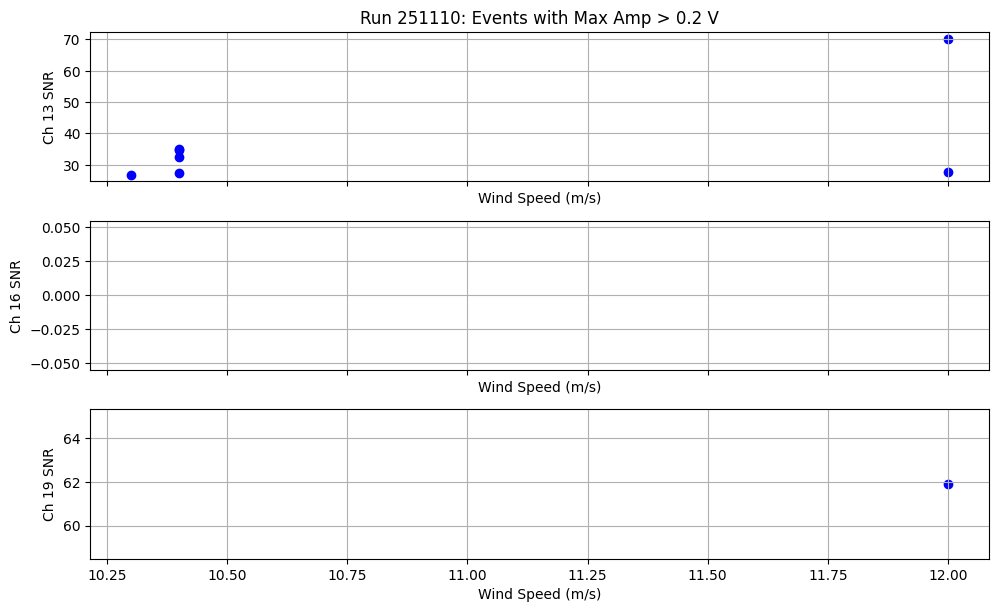

In [ ]:
from NuRadioReco.utilities.fft import time2freq, freq2time, freqs
thresh = 0.2
snr = {}; noise = {}; 
for ch in lpdas:
    snr[ch] = {}; noise[ch] = {}
    max_adc = [np.max(volts[runs[run_id]][eve][ch]) for eve in range(len(volts[runs[run_id]]))]
    hw_ids = [eve_id for eve_id in range(len(events[runs[run_id]])) if np.max(volts[runs[run_id]][eve_id][ch]) > thresh]
    for id in hw_ids:
        trace = volts[runs[run_id]][id][ch]
        time = times[runs[run_id]][id][ch]
        vpk_pk = (np.max(trace) - np.min(trace))*0.5
        noise[ch][id] = np.sqrt(np.mean(trace[:200]**2))
        snr[ch][id] = vpk_pk / noise[ch][id]

fig,ax = plt.subplots(3,1, figsize=(10,6), sharex=True)
for i, ch in enumerate([13,16,19]):
    eve_nums = [events[runs[run_id]][id] for id in snr[ch].keys()]
    ws = [wind_speeds[events[runs[run_id]][id]] for id in snr[ch].keys()]
    # ax[i].plot(ws, list(snr[ch].values()), label=f'SNR', ls='--', color='grey')
    ax[i].scatter(ws, list(snr[ch].values()), label=f'SNR', color='blue')
    # ax[i].scatter(ws, list(noise[ch].values()), label=f'Noise', color='orange')
    # ax[i].set_xlim(7000,)
    ax[i].set_xlabel('Wind Speed (m/s)')
    ax[i].set_ylabel(f'Ch {ch} SNR')
    ax[i].grid()
plt.tight_layout()
ax[0].set_title(f'Run {runs[run_id]}: Events with Max Amp > {thresh} V')
# plot the corresponding timestamps on top x-axis in ax[0]
# ax2 = ax[0].twiny()
# ax2.set_xlim(ax[0].get_xlim())


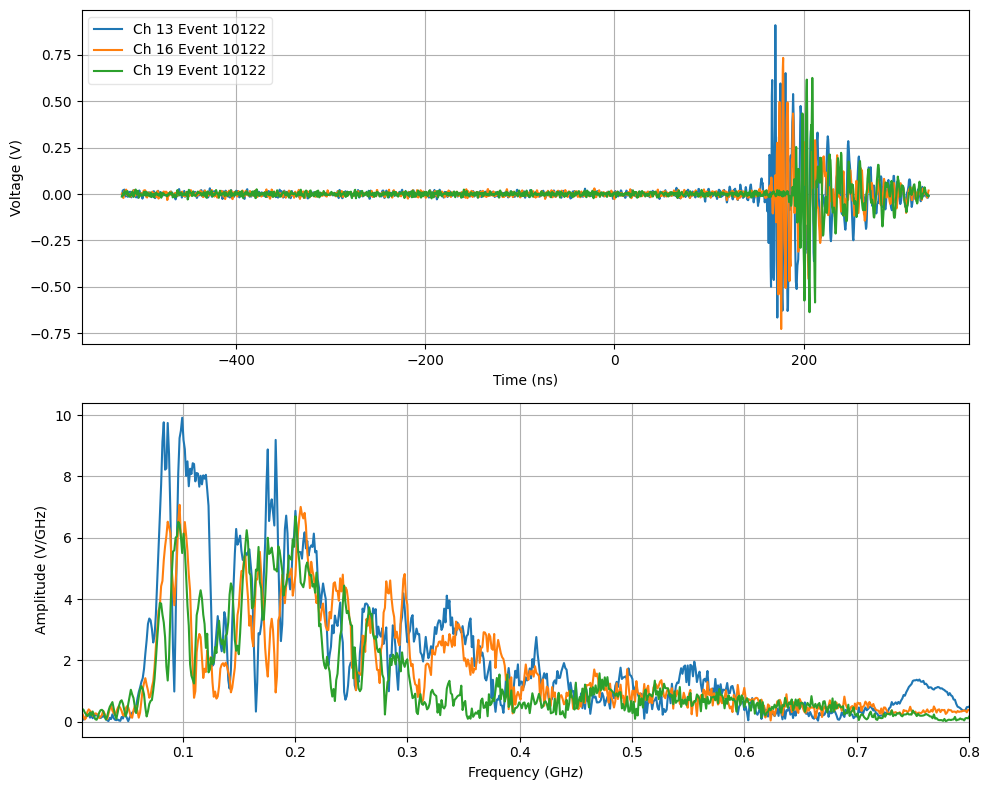

In [ ]:
# event_num = np.uint32(10122)
fig, ax = plt.subplots(2,1, figsize=(10, 8))
# pos = np.where(events[runs[run_id]]==event_num)
for chs in [13]:
    for eve_id in snr[chs].keys():
        ax[0].plot(times[runs[run_id]][eve_id][chs], volts[runs[run_id]][eve_id][chs],
                label=f'Ch {chs} Event {events[runs[run_id]][eve_id]}')
        ax[1].plot(freqs(len(times[runs[run_id]][eve_id][chs]),2.4*units.GHz), np.abs(time2freq(volts[runs[run_id]][eve_id][chs], 2.4*units.GHz)),
                label=f'Ch {chs} Event {events[runs[run_id]][eve_id]} freq')
ax[0].legend(ncols=1, fancybox=True, framealpha=0.5)
ax[0].grid()
ax[1].grid()
ax[0].set_xlabel('Time (ns)')
ax[0].set_ylabel('Voltage (V)')
ax[1].set_xlim(0.01,0.8)
ax[1].set_xlabel('Frequency (GHz)')
ax[1].set_ylabel('Amplitude (V/GHz)')
plt.tight_layout()